# Inverse dynamics regression

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import (plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions)
from vct.bokeh_plotting import create_tab
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (15,10)
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm

Loading BokehJS ...

In [3]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

models_ID_hull = catalog.load(f"{ship}.models_ID_hull")
models_ID_hull_rudder = catalog.load(f"{ship}.models_ID_hull_rudder")
models_VCT_hull_rudder = catalog.load(f"{ship}.models_rudder_VCT_MDL")
models_VCT_MDL_optimize = catalog.load(f"{ship}.models_VCT_MDL_optimize")
models_VCT_MDL = catalog.load(f"{ship}.models_VCT_MDL")


df_VCT = catalog.load(f"{ship}.df_VCT")
resistance_MDL = catalog.load(f"{ship}.resistance_MDL")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")
tests_ek = catalog.load(f"{ship}.tests_ek")

mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion

time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
#tests_ek_smooth_joined = catalog.load(f"{ship}.tests_ek_smooth_joined")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

df_VCT = catalog.load(f"{ship}.df_VCT")
mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion


[12/21/23 18:09:01] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=895034;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775152;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull' (PartitionedDataset)...    ]8;id=627707;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=25811;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder'                     ]8;id=566302;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=449351;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_rudder_VCT_MDL'                     ]8;id=798025;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=24234;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT_MDL_optimize'                   ]8;id=70434;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=383869;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=696159;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=136522;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=966439;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=644362;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.resistance_MDL' (CSVDataSet)...            ]8;id=239162;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160134;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=357842;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=631222;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek' (PartitionedDataset)...          ]8;id=134499;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=527804;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=93892;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=109909;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=675686;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=851543;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[12/21/23 18:09:02] INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=973376;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=941969;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

## MDL model tests

(-7.959039314187163, 5.473434028312597, -2.4314697708749473, 58.1052401146274)

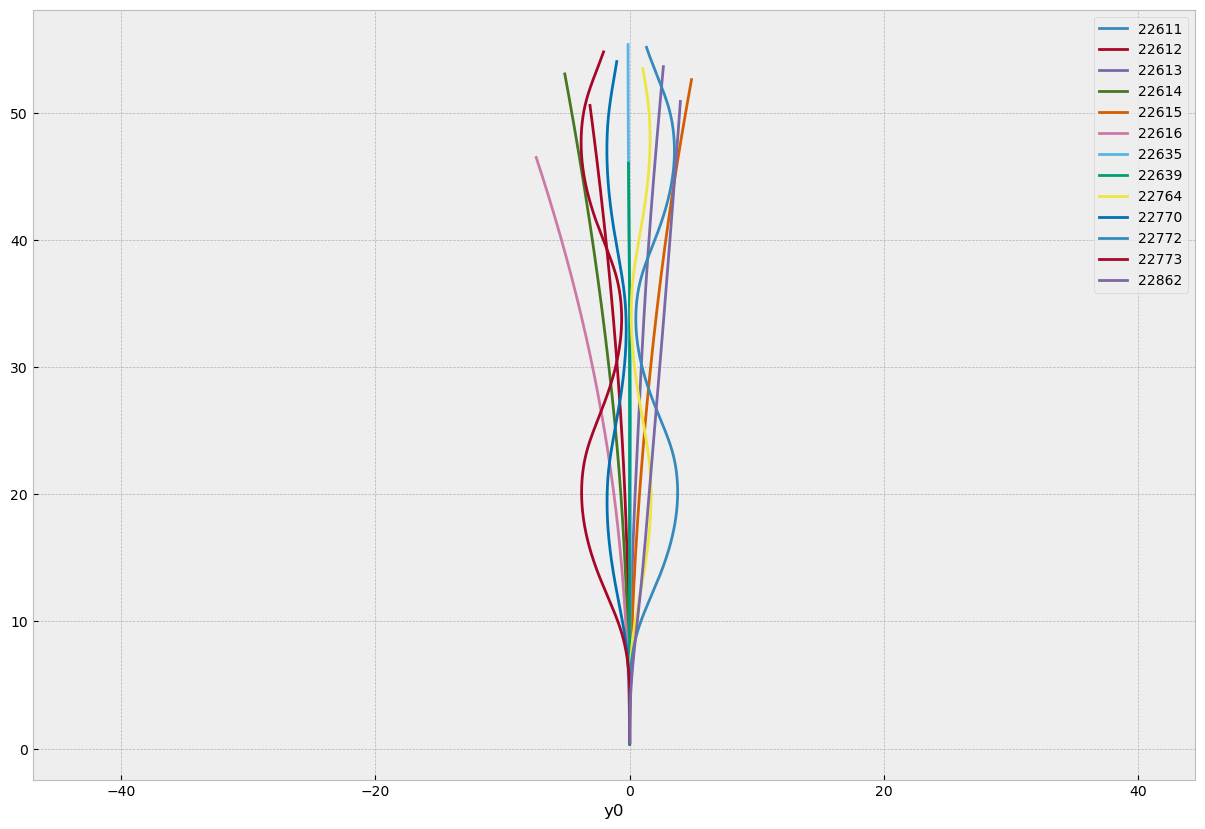

In [4]:
fig,ax=plt.subplots()

mask = tests_ek_joined['id'].isin([
    #22774,  # Circle
    #22611,
    #22635,
    #22639,
    22769,
    22771,
])

tests_ek_smooth_joined = tests_ek_joined.loc[~mask].copy()

for id, group in tests_ek_smooth_joined.groupby(by='id'):
    group[['x0','y0']].rolling(window=100).mean().plot(x='y0',y='x0', label=id, ax=ax)
ax.axis('equal')

In [10]:
model_ID_hull = models_ID_hull['semiempirical_covered']()

In [11]:
model_abkowitz_ID = models_ID_hull_rudder['Abkowitz']()

In [12]:
model_VCT_MDL = models_VCT_MDL['semiempirical_covered']()

In [13]:
model_abkowitz_VCT_MDL = models_VCT_hull_rudder['Abkowitz']()

In [8]:
#id = 22773
id = 22772
#id = 22770
#id = 22764
#id = 22774
#id = 22616  # Spiral


data_MDL = tests_ek[f'{id}']()
#data_MDL = tests_ek_smooth[f'{id}']()

data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
data_MDL['twa']=0
data_MDL['tws']=0
data_MDL['theta']=0
data_MDL['q']=0
data_MDL['phi'] = data_MDL['roll']
data_MDL['p'] = 0
data_MDL['q1d'] = 0
data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']
data_MDL['beta_deg'] =  np.rad2deg(data_MDL['beta'])

In [16]:
styles = {
    "Experiment": {
        "style": "-",
        "color": "black",
        "zorder": -10,
        "lw": 1.0,
        "label": "Experiment",
    },
    'model VCT': {
        "style": "--",
        "color": "green",
        "zorder": -10,
        "lw": 1.0,
        "label": 'model VCT',
    },
    "Abkowitz VCT": {
        "style": "--",
        "color": "magenta",
        "zorder": -10,
        "lw": 1.0,
        "label": "Abkowitz VCT",
    },
    "model ID": {
        "style": "-",
        "color": "green",
        "zorder": -10,
        "lw": 1.0,
        "label": "model ID",
    },
    "Abkowitz ID": {
        "style": "-",
        "color": "magenta",
        "zorder": -10,
        "lw": 1.0,
        "label": "Abkowitz ID",
    },
}


models = {
    #'VCT optimized' : model_VCT_MDL_optimize,
    
    'model VCT' : model_VCT_MDL,
    'model ID' : model_ID_hull,
    
    'Abkowitz VCT': model_abkowitz_VCT_MDL,
    'Abkowitz ID' : model_abkowitz_ID,
}

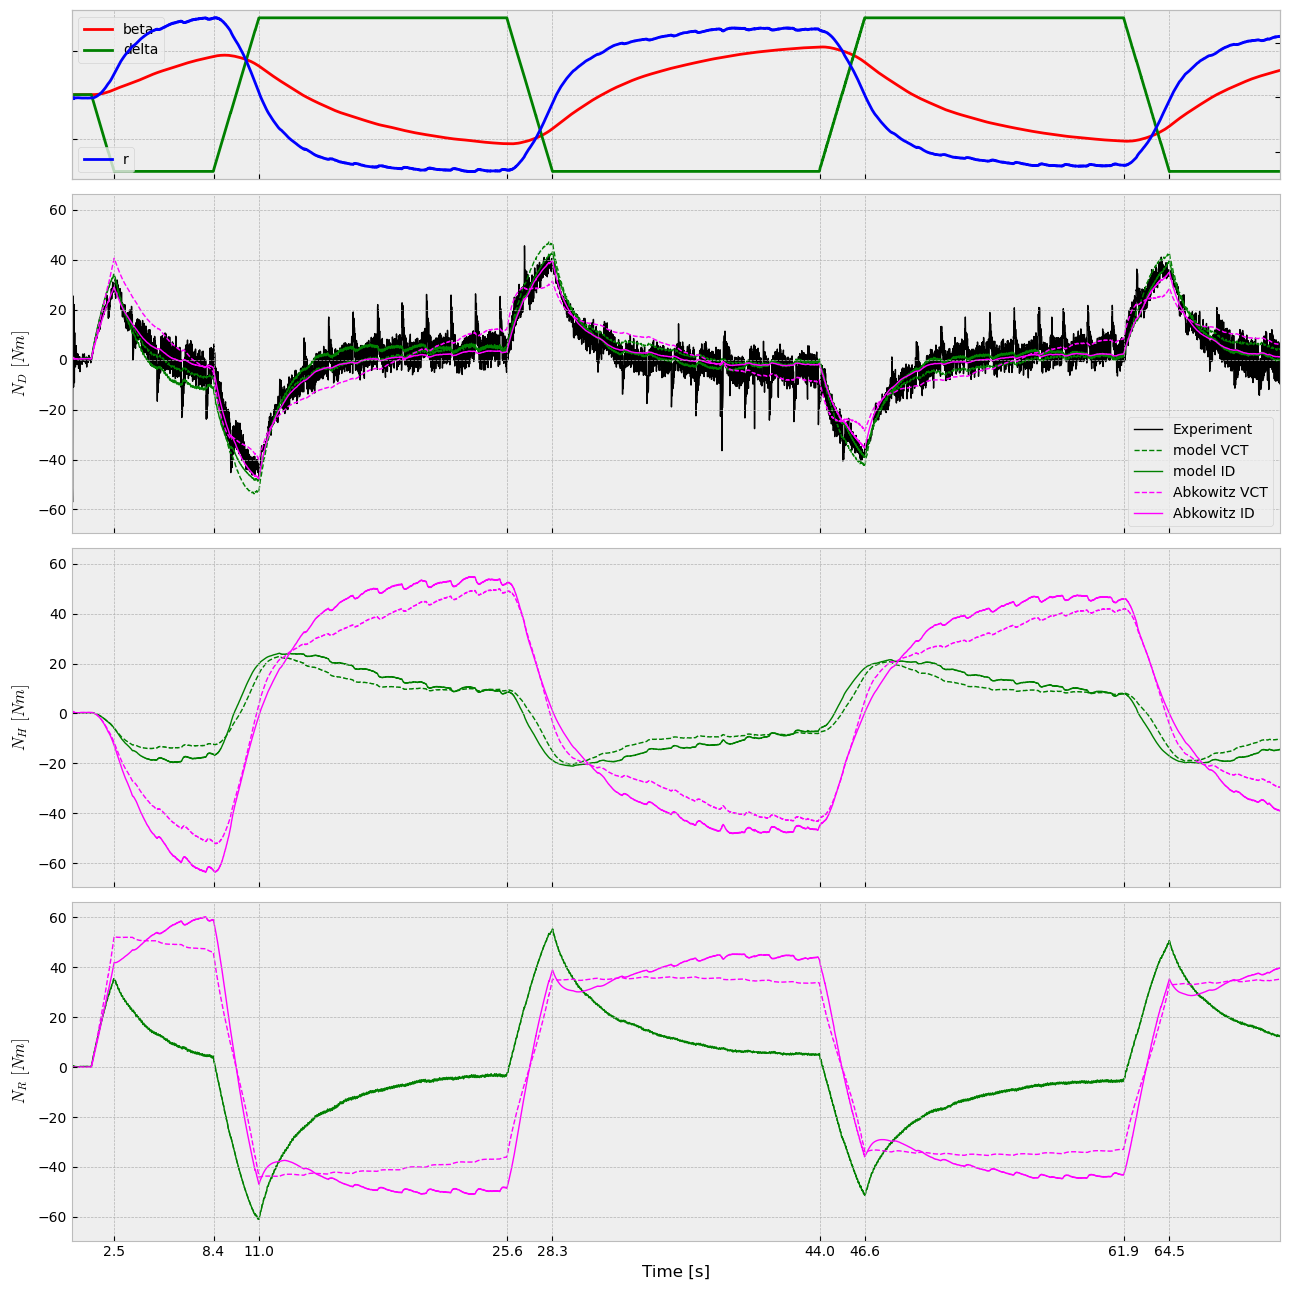

In [17]:
plot_compare_model_forces(model=model_VCT_MDL, models=models, data=data_MDL, styles=styles, keys=['N_D','N_H','N_R'])

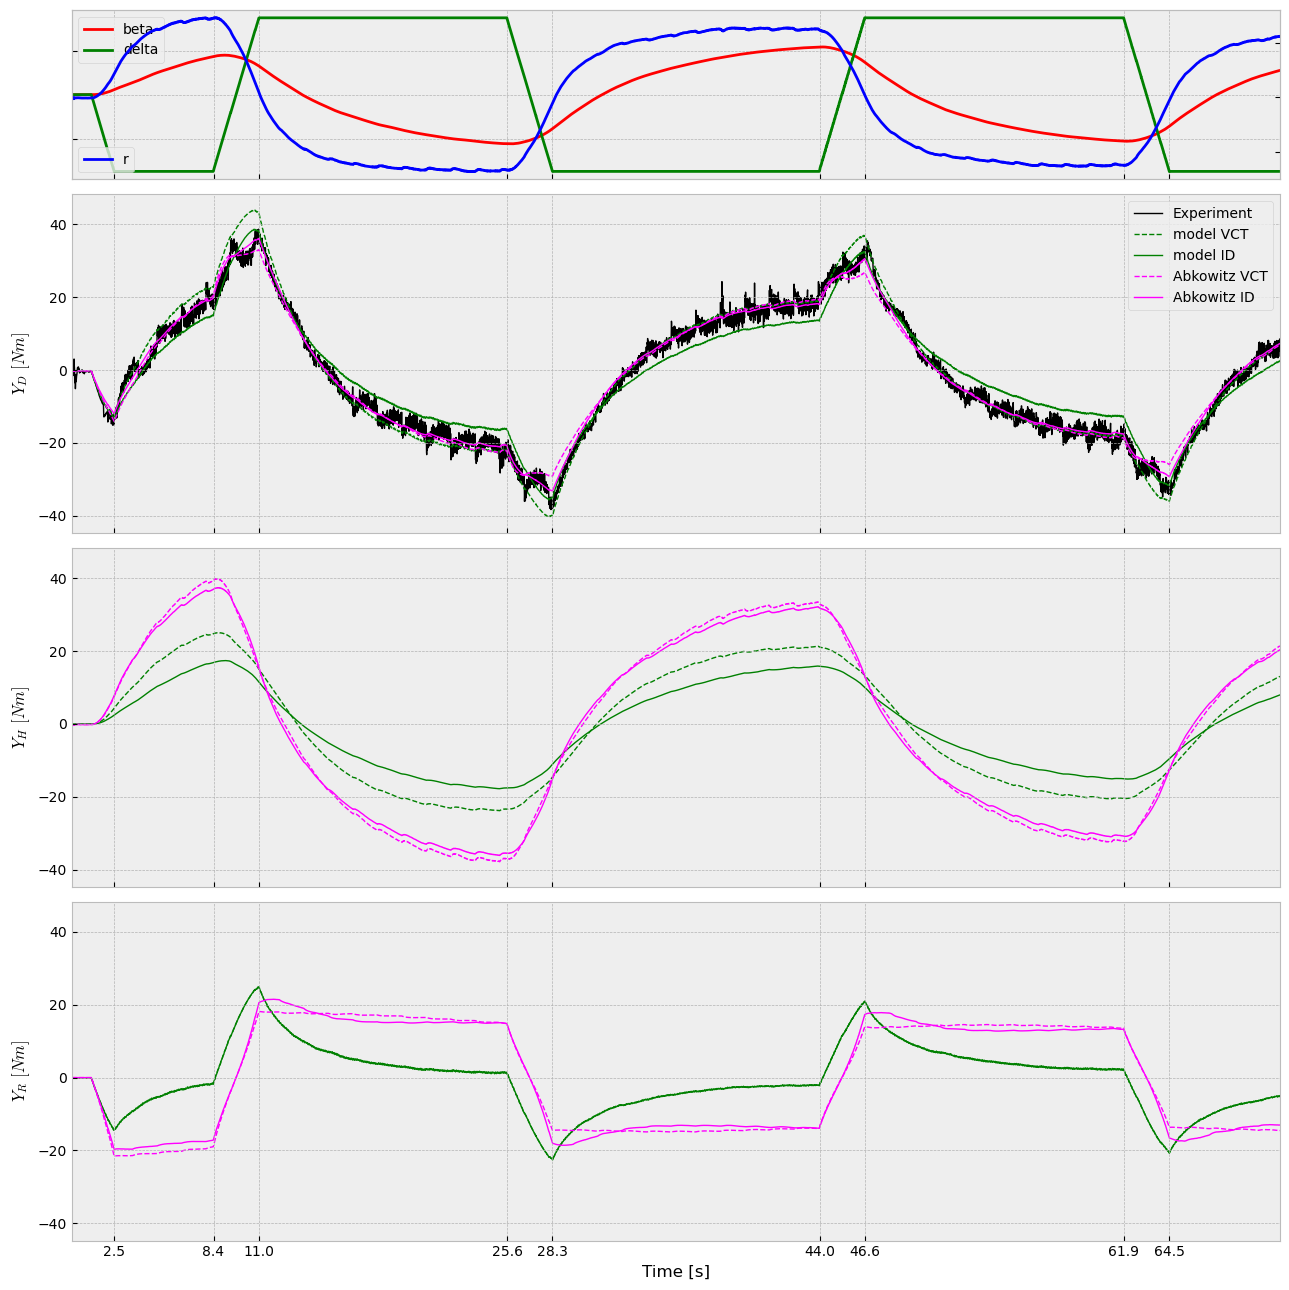

In [18]:
plot_compare_model_forces(model=model_VCT_MDL, models=models, data=data_MDL, styles=styles, keys=['Y_D','Y_H','Y_R'])

## Simulations
Open loop simulations.

In [19]:
dataframes = {
    'Experiment':data_MDL,
}
for name, model in models.items():
    dataframes[name] = model.simulate(data_MDL)

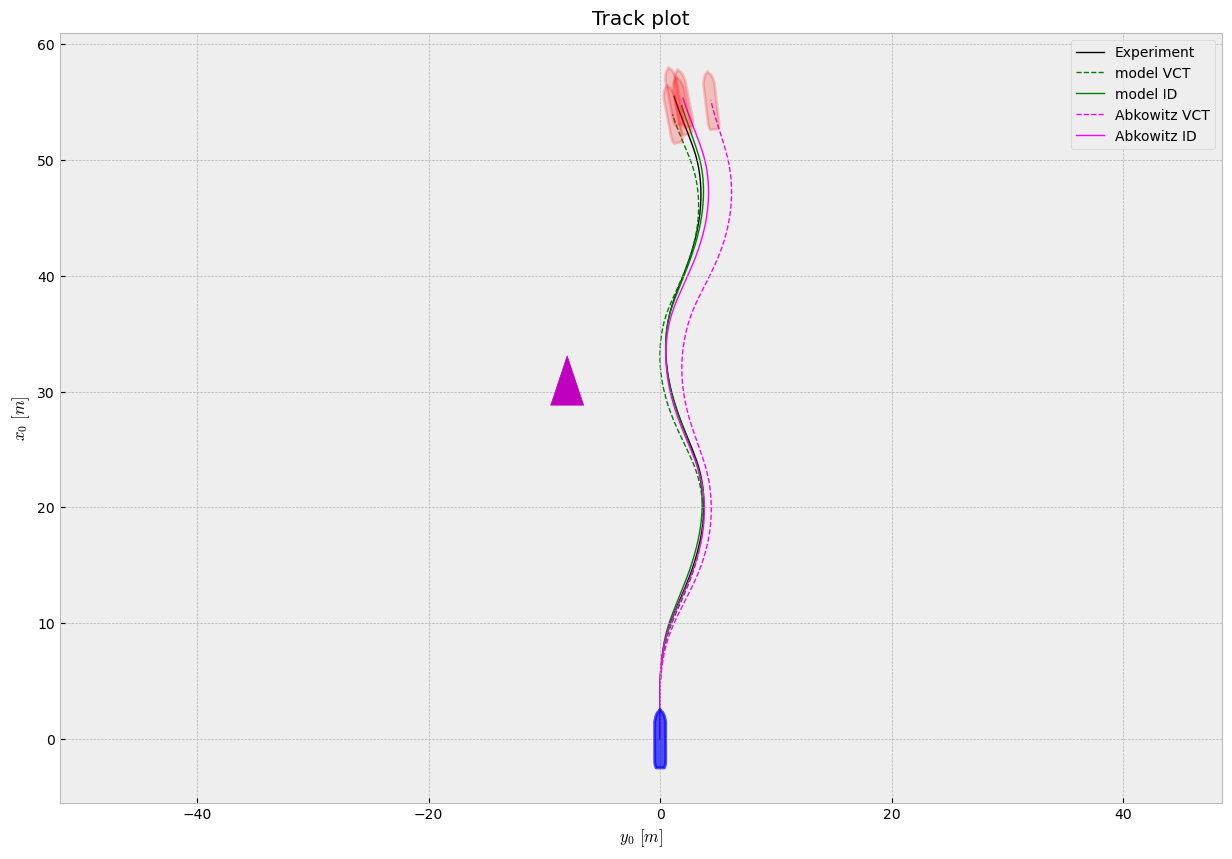

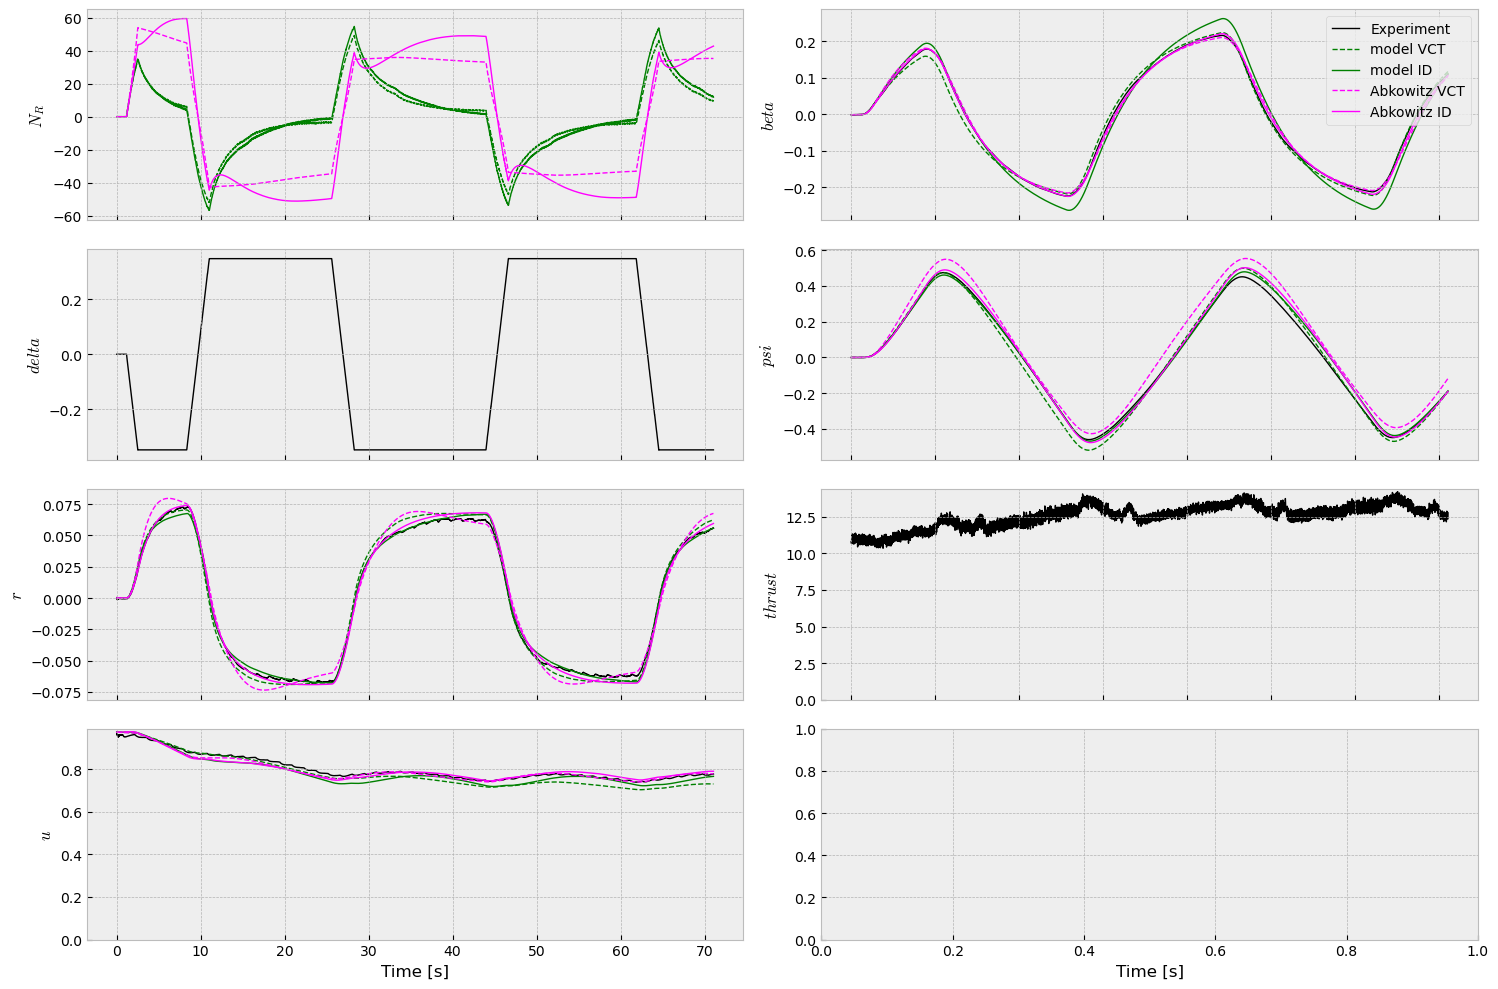

In [20]:
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], styles=dict(styles), N=2);
plot(dataframes=dataframes, keys=['u','thrust','r','beta','delta','psi','N_R'], styles=dict(styles));

## Parameter decomposition
The predicted forces can be decomposed into the various parameter contributions. It can be seen that the `model` and `Abkowitz` have very different decompositions, eventhough the simulations results above are similar. The contributions from the Nr and Nrrr coefficients are very large for the `Abkowitz`.

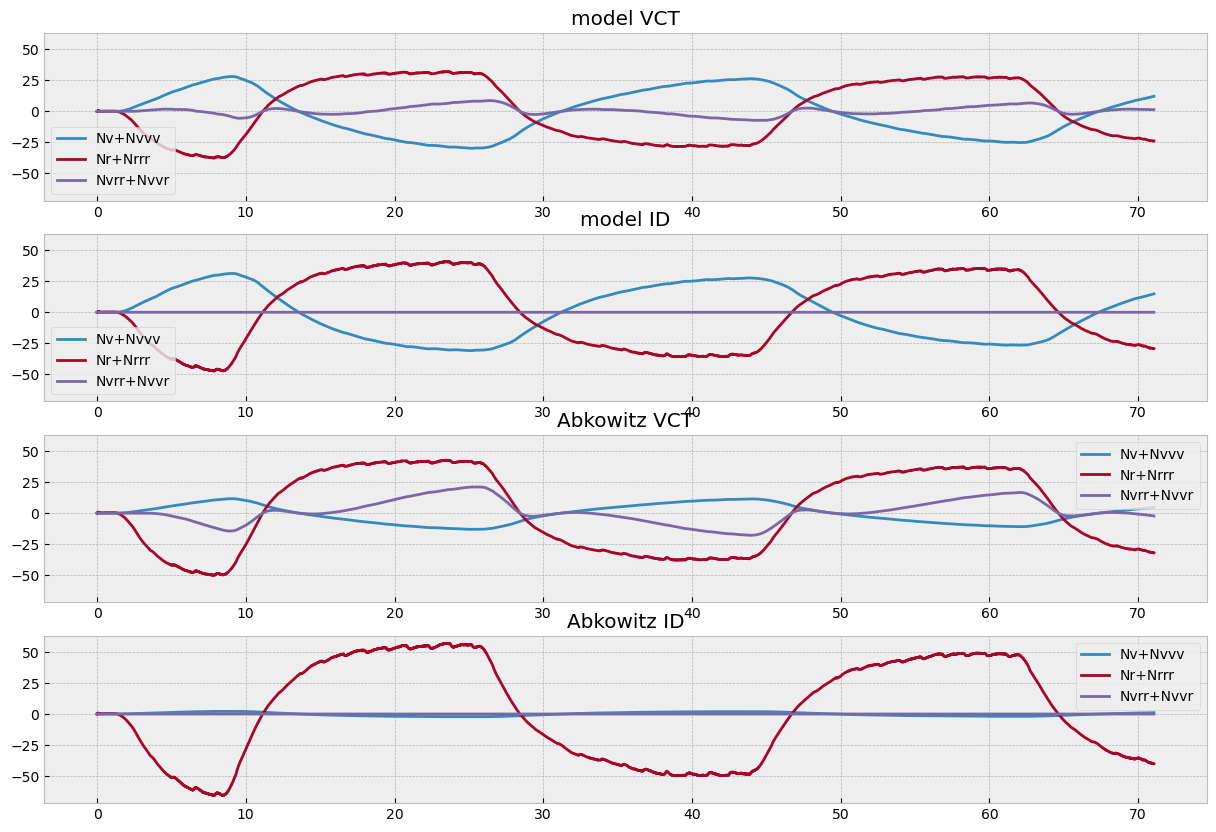

In [22]:
fig,axes=plt.subplots(nrows=len(models))

for ax, (name, model) in zip(axes,models.items()):
                      
    ax.set_title(name)
    plot_parameter_contributions(model=model, data=data_MDL, ax=ax, prefix='N', unit='moment')

ylims = []
for ax in axes:
    ylims.append(ax.get_ylim())
    
ylims = [np.min(ylims, axis=0)[0],np.max(ylims, axis=0)[1]]
for ax in axes:
    ax.set_ylim(ylims) 

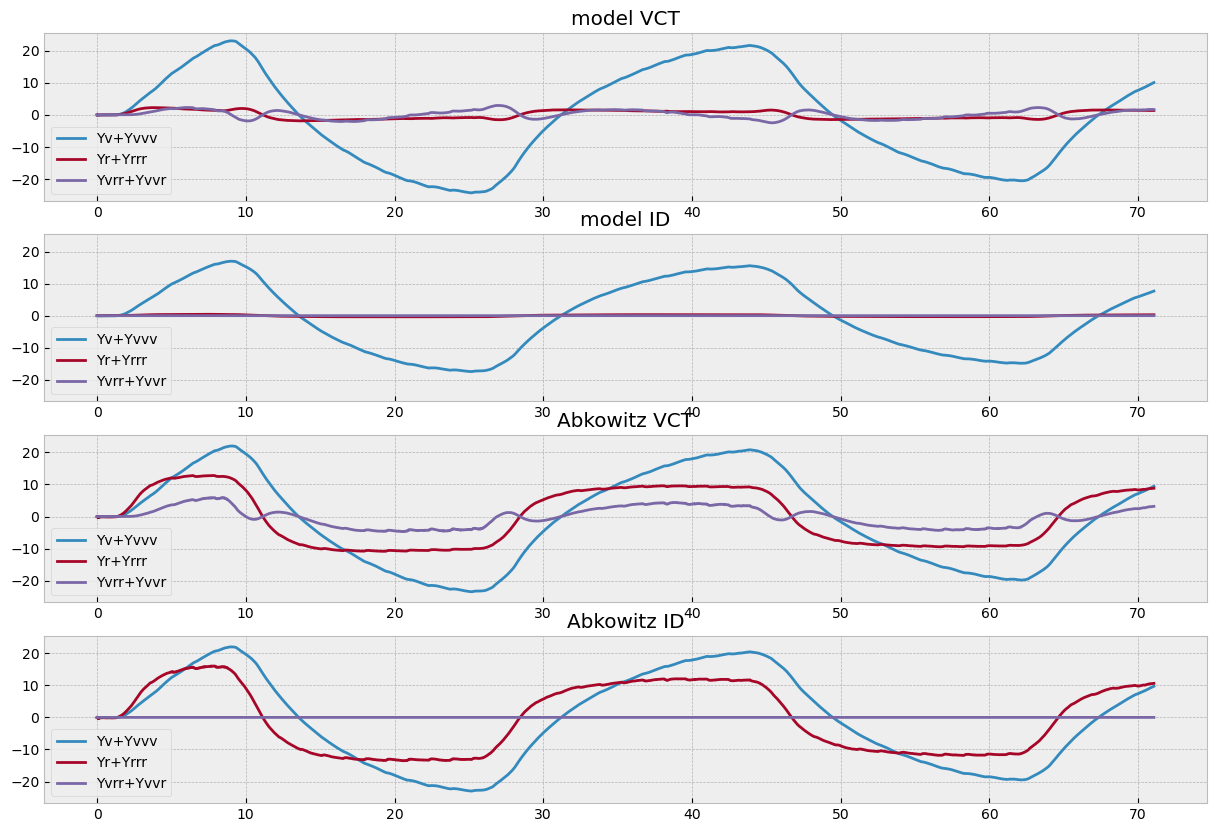

In [21]:
fig,axes=plt.subplots(nrows=len(models))

for ax, (name, model) in zip(axes,models.items()):
                      
    ax.set_title(name)
    plot_parameter_contributions(model=model, data=data_MDL, ax=ax, prefix='Y', unit='force')

ylims = []
for ax in axes:
    ylims.append(ax.get_ylim())
    
ylims = [np.min(ylims, axis=0)[0],np.max(ylims, axis=0)[1]]
for ax in axes:
    ax.set_ylim(ylims) 